# Speech Recognition with Neural Networks

## Introduction

This notebook provides code for a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline. It accepts raw audio as input and returns a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

This project uses the [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) dataset ([download](http://www.openslr.org/12/)), which is a large corpus of English-read speech.

In the code cells below, we will use the `vis_train_features` module to visualize a training example. The optional argument `index=0` tells the module to extract the first example in the training set. The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 5366 total training examples.


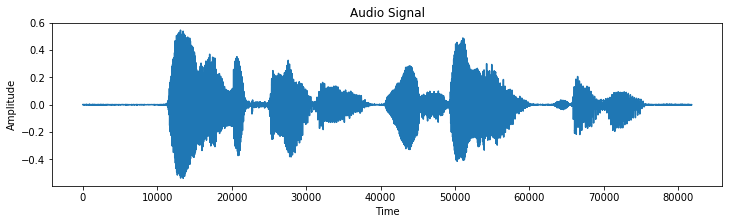

**Shape of Audio Signal** : (81806,)

**Transcript** : well look here then i'll show ye said he

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

plot_raw_audio(vis_raw_audio) # plot audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape))) # print length of audio signal
display(Markdown('**Transcript** : ' + str(vis_text))) # print transcript corresponding to audio clip
Audio(vis_audio_path) # play the audio file

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

We first perform a preprocessing step to convert the raw audio to a feature representation which has historically proven successful for ASR models. Processing with raw audio [is also possible](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

One option is to use spectrograms. The code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech), implemented in `utils.py`. The code below returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency. To speed the convergence, it has been normalized.

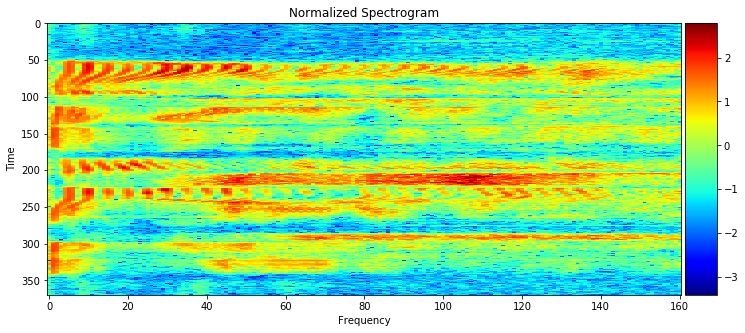

**Shape of Spectrogram** : (370, 161)

In [3]:
from data_generator import plot_spectrogram_feature

plot_spectrogram_feature(vis_spectrogram_feature) # plot normalized spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape))) # print shape of spectrogram

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

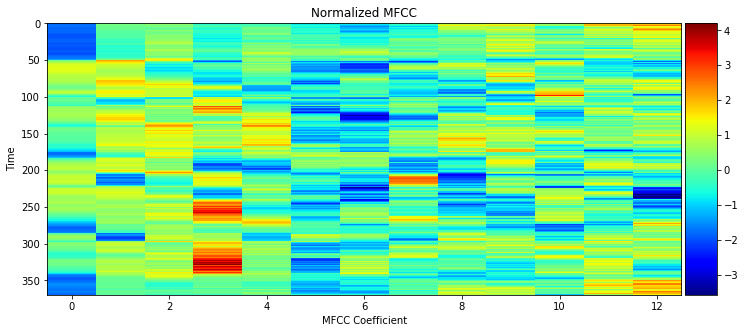

**Shape of MFCC** : (370, 13)

In [4]:
from data_generator import plot_mfcc_feature

plot_mfcc_feature(vis_mfcc_feature) # plot normalized MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape))) # print shape of MFCC

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

This section experiments with various neural network architectures for acoustic modeling. All models are specified in the `sample_models.py` file.

In [14]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# # allocate 80% of GPU memory (if you like, feel free to change this)
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8
# set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2

from sample_models import * # import NN architectures for speech recognition
from train_utils import train_model # import function for training acoustic model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model is an RNN, which will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence (the extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.), see `char_map.py`.

The acoustic model will be trained with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.

There are several optional arguments:
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

In [6]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 81s 762ms/step - loss: 831.0760 - val_loss: 741.7613
Epoch 2/20
106/106 [==============================] - 82s 771ms/step - loss: 763.1293 - val_loss: 724.7989
Epoch 3/20
106/106 [==============================] - 82s 776ms/step - loss: 751.5481 - val_loss: 725.4296
Epoch 4/20
106/106 [==============================] - 81s 766ms/step - loss: 751.1594 - val_loss: 724.1593
Epoch 5/20
106/106 [==============================] - 81s 763ms/step - loss: 752.5229 - val_loss: 728.0555
Epoch 6/20
106/106 [==============================] - 82s 773ms/step - loss: 751.3231 - val_loss: 731.0923
Epoch 7/20
106/106 [==============================] - 82s 778ms/step - loss: 751.8558 - val_loss: 728.5943
Epoch 8/20
106/106 [==============================] - 81s 762ms/step - loss: 752.9525 - val_loss: 719.9739
Epoch 9/20
106/106 [==============================] - 81s 765ms/step - loss: 751.8618 - val_loss: 725.5093
Epoch 10/20
106/106 [================

<a id='model1'></a>
### Model 1: RNN + TimeDistributed Dense

The next architecture introduces [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times, and a dense prediction layer applied to each time step.

<img src="images/rnn_model.png" width="60%">

In [7]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


In [9]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 85s 800ms/step - loss: 340.0115 - val_loss: 312.4131
Epoch 2/20
106/106 [==============================] - 82s 769ms/step - loss: 265.0944 - val_loss: 235.2511
Epoch 3/20
106/106 [==============================] - 83s 783ms/step - loss: 208.2538 - val_loss: 212.6455
Epoch 4/20
106/106 [==============================] - 83s 784ms/step - loss: 184.5194 - val_loss: 177.5573
Epoch 5/20
106/106 [==============================] - 82s 769ms/step - loss: 168.6558 - val_loss: 170.9032
Epoch 6/20
106/106 [==============================] - 84s 793ms/step - loss: 159.5717 - val_loss: 165.3273
Epoch 7/20
106/106 [==============================] - 82s 778ms/step - loss: 153.8452 - val_loss: 154.7321
Epoch 8/20
106/106 [==============================] - 82s 774ms/step - loss: 149.7783 - val_loss: 161.6739
Epoch 9/20
106/106 [==============================] - 82s 774ms/step - loss: 145.8047 - val_loss: 150.0036
Epoch 10/20
106/106 [================

<a id='model2'></a>
### Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

In [8]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [11]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 46s 435ms/step - loss: 222.8990 - val_loss: 197.8689
 - val_wer: 14.12
Epoch 2/20
106/106 [==============================] - 45s 422ms/step - loss: 171.5634 - val_loss: 164.2151
 - val_wer: 13.95
Epoch 3/20
106/106 [==============================] - 46s 432ms/step - loss: 149.8251 - val_loss: 148.0557
 - val_wer: 13.85
Epoch 4/20
106/106 [==============================] - 46s 429ms/step - loss: 137.1076 - val_loss: 142.4170
 - val_wer: 14.61
Epoch 5/20
106/106 [==============================] - 45s 428ms/step - loss: 127.9951 - val_loss: 138.7907
 - val_wer: 13.62
Epoch 6/20
106/106 [==============================] - 46s 431ms/step - loss: 120.2984 - val_loss: 130.1452
 - val_wer: 13.71
Epoch 7/20
106/106 [==============================] - 46s 434ms/step - loss: 113.8393 - val_loss: 132.3798
 - val_wer: 13.63
Epoch 8/20
106/106 [==============================] - 46s 432ms/step - loss: 108.7703 - val_loss: 130.6289
 - val_wer: 14.04


<a id='model3'></a>
### Model 3: Deeper RNN + TimeDistributed Dense

Instead of one layer, the following model trains with two RNN layers with batch normalization.

<img src="images/deep_rnn_model.png" width="80%">

In [9]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


In [8]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 83s 780ms/step - loss: 283.2198 - val_loss: 216.9473
 - val_wer: 14.04
Epoch 2/20
106/106 [==============================] - 82s 771ms/step - loss: 206.0479 - val_loss: 189.7728
 - val_wer: 14.03
Epoch 3/20
106/106 [==============================] - 82s 777ms/step - loss: 186.0467 - val_loss: 184.5956
 - val_wer: 14.03
Epoch 4/20
106/106 [==============================] - 82s 774ms/step - loss: 169.3220 - val_loss: 164.1720
 - val_wer: 13.93
Epoch 5/20
106/106 [==============================] - 83s 783ms/step - loss: 157.6262 - val_loss: 156.2691
 - val_wer: 13.85
Epoch 6/20
106/106 [==============================] - 82s 770ms/step - loss: 150.2887 - val_loss: 151.0470
 - val_wer: 13.93
Epoch 7/20
106/106 [==============================] - 83s 779ms/step - loss: 144.2104 - val_loss: 146.2979
 - val_wer: 13.82
Epoch 8/20
106/106 [==============================] - 81s 768ms/step - loss: 139.4889 - val_loss: 143.4627
 - val_wer: 13.76


<a id='model4'></a>
### Model 4: Bidirectional RNN + TimeDistributed Dense

The next architecture uses a single [bidirectional RNN](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf) layer, before a (`TimeDistributed`) dense layer. This will allow the network to look forwards and backwards along the audio segment

<img src="images/bidirectional_rnn_model.png" width="80%">

In [10]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
brnn (Bidirectional)         (None, None, 400)         434400    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 400)         1600      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 447,629
Trainable params: 446,829
Non-trainable params: 800
_________________________________________________________________
None


In [7]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 152s 1s/step - loss: 449.6794 - val_loss: 419.7952
 - val_wer: 14.09
Epoch 2/20
106/106 [==============================] - 152s 1s/step - loss: 252.9730 - val_loss: 235.3296
 - val_wer: 14.04
Epoch 3/20
106/106 [==============================] - 150s 1s/step - loss: 208.5590 - val_loss: 190.6238
 - val_wer: 14.04
Epoch 4/20
106/106 [==============================] - 151s 1s/step - loss: 186.8903 - val_loss: 182.6424
 - val_wer: 13.98
Epoch 5/20
106/106 [==============================] - 152s 1s/step - loss: 172.7559 - val_loss: 168.9599
 - val_wer: 13.94
Epoch 6/20
106/106 [==============================] - 151s 1s/step - loss: 161.6241 - val_loss: 162.4615
 - val_wer: 13.91
Epoch 7/20
106/106 [==============================] - 152s 1s/step - loss: 152.6400 - val_loss: 154.8290
 - val_wer: 13.84
Epoch 8/20
106/106 [==============================] - 150s 1s/step - loss: 145.3490 - val_loss: 149.8154
 - val_wer: 13.75
Epoch 9/20
106/1

<a id='model5'></a>
### Model 5: CNN + BRNN x2 + TimeDistributed Dense

The next model incorporates the ideas of all previous models, with a starting convolutional layer, followed by two layers of bidirectional RNNs, and a dense prediction layer applied to each time step.

In [11]:
model_5 = cnn_brnn_model(input_dim=161,
                         filters=200,
                         kernel_size=11,
                         conv_stride=2,
                         rnn_units=200,
                         rnn_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
brnn_0 (Bidirectional)       (None, None, 400)         481200    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 400)         1600      
_________________________________________________________________
brnn_1 (Bidirectional)       (None, None, 400)         721200    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 400)         1600      
__________

In [9]:
train_model(input_to_softmax=model_5,
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 151s 1s/step - loss: 237.7390 - val_loss: 250.0412
 - val_wer: 14.02
Epoch 2/20
106/106 [==============================] - 148s 1s/step - loss: 184.2404 - val_loss: 161.0698
 - val_wer: 16.01
Epoch 3/20
106/106 [==============================] - 148s 1s/step - loss: 149.1333 - val_loss: 142.4036
 - val_wer: 13.71
Epoch 4/20
106/106 [==============================] - 148s 1s/step - loss: 131.8266 - val_loss: 144.1138
 - val_wer: 16.77
Epoch 5/20
106/106 [==============================] - 148s 1s/step - loss: 119.3716 - val_loss: 128.7111
 - val_wer: 13.55
Epoch 6/20
106/106 [==============================] - 144s 1s/step - loss: 109.4975 - val_loss: 122.9104
 - val_wer: 13.83
Epoch 7/20
106/106 [==============================] - 135s 1s/step - loss: 101.1452 - val_loss: 124.8199
 - val_wer: 14.13
Epoch 8/20
106/106 [==============================] - 139s 1s/step - loss: 93.0788 - val_loss: 118.9480
 - val_wer: 13.96
Epoch 9/20
106/10

<a id='model5'></a>
### Model 6: Dilated CNN + BRNN x2 + TimeDistributed Dense

This model uses dilated convolutions of width 2.

In [12]:
model_6 = cnn_brnn_dilated_model(input_dim=161,
                                 filters=200,
                                 kernel_size=11,
                                 conv_stride=1,
                                 rnn_units=200,
                                 rnn_layers=2,
                                 dilation=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
brnn_0 (Bidirectional)       (None, None, 400)         481200    
_________________________________________________________________
bn_rnn_0 (BatchNormalization (None, None, 400)         1600      
_________________________________________________________________
brnn_1 (Bidirectional)       (None, None, 400)         721200    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 400)         1600      
__________

In [13]:
train_model(input_to_softmax=model_6, 
            pickle_path='model_6.pickle', 
            save_model_path='model_6.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 294s 3s/step - loss: 265.6727 - val_loss: 234.6400
 - val_wer: 13.97
Epoch 2/20
106/106 [==============================] - 293s 3s/step - loss: 223.4905 - val_loss: 205.6557
 - val_wer: 14.04
Epoch 3/20
106/106 [==============================] - 281s 3s/step - loss: 204.9829 - val_loss: 179.2857
 - val_wer: 14.01
Epoch 4/20
106/106 [==============================] - 274s 3s/step - loss: 176.1265 - val_loss: 166.0279
 - val_wer: 14.56
Epoch 5/20
106/106 [==============================] - 278s 3s/step - loss: 152.8821 - val_loss: 146.3251
 - val_wer: 14.47
Epoch 6/20
106/106 [==============================] - 303s 3s/step - loss: 137.5567 - val_loss: 139.9135
 - val_wer: 15.98
Epoch 7/20
106/106 [==============================] - 304s 3s/step - loss: 125.7727 - val_loss: 135.5229
 - val_wer: 15.16
Epoch 8/20
106/106 [==============================] - 315s 3s/step - loss: 117.9650 - val_loss: 127.7317
 - val_wer: 13.74
Epoch 9/20
106/1

<a id='model5'></a>
### Model 7: CNN + BRNN x2 + TimeDistributed Dense + dropout + 100 hours

This model uses dropout, and 100 hours of clean speech for training.

In [30]:
model_7 = cnn_brnn_dropout_model(input_dim=161,
                                 filters=400,
                                 kernel_size=11,
                                 conv_stride=2,
                                 rnn_units=200,
                                 rnn_layers=2,
                                 dropout=0.5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 400)    708800      the_input[0][0]                  
__________________________________________________________________________________________________
bn_conv_1d (BatchNormalization) (None, None, 400)    1600        conv1d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, None, 400)    0           bn_conv_1d[0][0]                 
__________________________________________________________________________________________________
dropout_34

In [31]:
train_model(input_to_softmax=model_7, 
            pickle_path='model_7.pickle', 
            save_model_path='model_7.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
268/268 [==============================] - 380s 1s/step - loss: 291.6633 - val_loss: 187.1857
 - val_wer: 15.00
Epoch 2/20
268/268 [==============================] - 391s 1s/step - loss: 194.9032 - val_loss: 148.5242
 - val_wer: 14.67
Epoch 3/20
268/268 [==============================] - 382s 1s/step - loss: 173.5893 - val_loss: 137.0701
 - val_wer: 14.17
Epoch 4/20
268/268 [==============================] - 379s 1s/step - loss: 163.3789 - val_loss: 129.5856
 - val_wer: 14.62
Epoch 5/20
268/268 [==============================] - 377s 1s/step - loss: 156.5767 - val_loss: 123.2262
 - val_wer: 13.84
Epoch 6/20
268/268 [==============================] - 379s 1s/step - loss: 152.1965 - val_loss: 119.7334
 - val_wer: 13.76
Epoch 7/20
268/268 [==============================] - 380s 1s/step - loss: 149.2846 - val_loss: 118.9842
 - val_wer: 13.62
Epoch 8/20
268/268 [==============================] - 383s 1s/step - loss: 148.1591 - val_loss: 119.4908
 - val_wer: 13.54
Epoch 9/20
268/2

KeyboardInterrupt: 

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

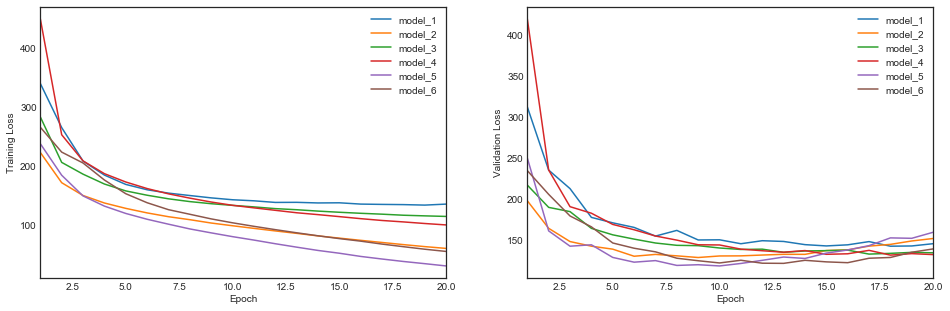

In [31]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/model*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [32]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

In [33]:
final_model = model_7
model_path = 'results/model_7.h5'

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [34]:
get_predictions(index=0,
                partition='train',
                input_to_softmax=final_model,
                model_path=model_path)

--------------------------------------------------------------------------------
True transcription:

well look here then i'll show ye said he
--------------------------------------------------------------------------------
Predicted transcription:

ron loker thea a shuly sy y
--------------------------------------------------------------------------------


Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [36]:
get_predictions(index=1,
                partition='validation',
                input_to_softmax=final_model,
                model_path=model_path)

--------------------------------------------------------------------------------
True transcription:

we range wider last longer and escape more and more from intensity towards understanding
--------------------------------------------------------------------------------
Predicted transcription:

we ring sride las gonver and e spap orat or fomin hans ote porconder sonting
--------------------------------------------------------------------------------


One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!

## Credits
Project code adapted from https://github.com/udacity/AIND-VUI-Capstone.